In [30]:
import matplotlib.pyplot as plt
import numpy as np
from util.functions import get_data_ticker, dias_uteis_entre_datas, decompor_sinal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
import util.functions as funcs
from sklearn.model_selection import train_test_split
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import plotly.graph_objs as go
from pandas.tseries.offsets import BDay

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from util.functions import get_data_ticker, decompor_sinal, obter_sazonalidade_periodo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import plot_tree



In [31]:
#EMPRESA = 'ELET3.SA'
#EMPRESA = 'B3SA3.SA'
EMPRESA = 'VALE3.SA'


#EMPRESA = 'ITUB4.SA'
#EMPRESA = 'PETR4.SA'
SEED = 42
qtdTreino = .8

# features = ['Close', 'prev-day-1', 'prev-day-2', 'prev-day-3', 'mm_5', 'mm_21', 'Close_diff']
features = ['Close','Close_diff', 'mm_5', 'mm_21', 'RSI_14']
features_trend = ['Close','tomorrow']
target = 'tomorrow'

n_past = 20
days_to_predict = 35
# n_features = len(features)

np.random.seed(SEED)
tf.random.set_seed(SEED)

### Funções

In [32]:
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

In [33]:
def prepare_new_record(df, new_record, date_index, rolling=1):
    data_orig = pd.DataFrame({'Close': new_record}, index=[date_index])
    data_orig = data_orig.rename_axis('Date')
    data_orig = pd.concat([df,data_orig])
    data_hist = pd.DataFrame(data_orig['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].rolling(rolling).mean().shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].rolling(rolling).mean().shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].rolling(rolling).mean().shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist['tomorrow'] = data_hist['Close'].rolling(rolling).mean().shift(-1)
    data_hist['Close_diff'] = data_hist['Close'].diff(1)
    # Ajuste para o último registro
    if len(data_hist) > 1:
        data_hist.iloc[-1, data_hist.columns.get_loc('Close_diff')] = data_hist['Close'].iloc[-1] - data_hist['Close'].iloc[-2]
    else:
        data_hist['Close_diff'].iloc[-1] = 0  # Define 0 caso não haja histórico suficiente

    data_hist['tomorrow'].fillna(0, inplace = True)
    delta = data_hist['Close'].diff(1)
    gain = delta.where(delta > 0, 0)  # Ganhos
    loss = -delta.where(delta < 0, 0)  # Perdas
    avg_gain = gain.rolling(window=14, min_periods=1).mean()  # Média de ganhos
    avg_loss = loss.rolling(window=14, min_periods=1).mean()  # Média de perdas
    rs = avg_gain / avg_loss  # Cálculo do RS (força relativa)
    rsi = 100 - (100 / (1 + rs))  # Cálculo do RSI
    data_hist['RSI_14'] = rsi 
    return data_hist.tail(1)

In [34]:
def increment_data_df(df, last_predict, offset=0):
   if df.tail(1)['tomorrow'].values[0] == 0:
      return df
   # dia_util = gerar_dias_uteis(1, offset)[0]
   last_date = df.index[-1]
   dia_util = pd.date_range(start=last_date + BDay(1), periods=1, freq=BDay())

   return pd.concat([df, prepare_new_record(df, last_predict, dia_util[0])])

In [35]:
def evaluate_model(y_true, y_pred):
    # Calcular as métricas de desempenho
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Criar um dicionário com as métricas
    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    
    return metrics

In [36]:
def aplicar_tendencia_coluna(df, coluna, period = 20):
    season = decompor_sinal(df[coluna], period=period, two_sided=False )
    tendencia = season.trend
    tendencia.dropna()
    df.loc[tendencia.dropna().index].copy()
    df[coluna] = tendencia

## Obter dados

In [37]:
dados = get_data_ticker(EMPRESA, period='5y')
dados['Close_diff'] = dados['Close'].diff().dropna()
dados.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [38]:
for f in features_trend:
    aplicar_tendencia_coluna(dados, f)

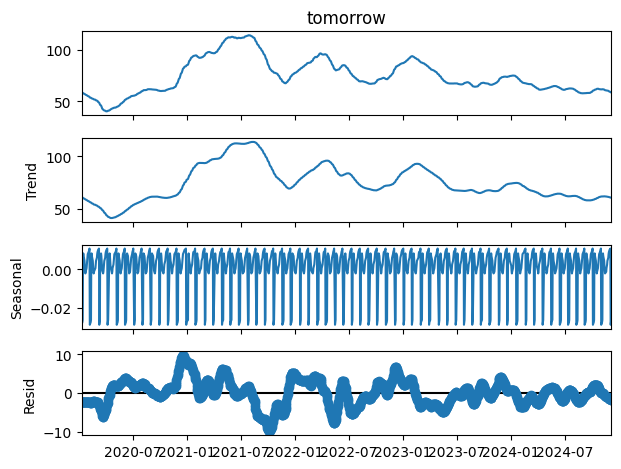

In [39]:
if 'tomorrow' in features_trend:
    season = decompor_sinal(dados['tomorrow'], period=20 )
    tendencia = season.trend

    season.plot()
    plt.show()

In [40]:
#plt.figure(figsize=(15,10))

#ax1 = plt.subplot2grid((10,1),(0,0), rowspan=4, colspan=1)
#ax2 = plt.subplot2grid((10,1),(5,0), rowspan=4, colspan=1)
#ax1.plot(dados['Close'])
#ax1.set_title('Preço de fechamento')

#ax2.plot(dados['Close_diff'])
#ax2.set_title('Percentual de diferença entre fechamentos')

Separando dados de treino e teste

In [41]:
def split_X_y(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), index=df.index, columns=features)
    X, y = create_sequences(df_scaled[features].values, df[target].values, n_past)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=qtdTreino, shuffle=False)
    return (X, y, X_train, X_test, y_train, y_test)

In [42]:
X, y, X_train, X_test, y_train, y_test = split_X_y(dados)

In [43]:
if 'Close' in features:
    close_index = features.index('Close')

    close_values= [X_train[i, :, close_index] for i in range(X_train.shape[0])]
    X_train_plot = [arr[0] for arr in close_values]

    close_values= [X_test[i, :, close_index] for i in range(X_test.shape[0])]
    X_test_plot = [arr[0] for arr in close_values]


In [44]:

dtr_plot = pd.DataFrame({'tomorrow':y_train})
dte_plot = pd.DataFrame({'tomorrow':y_test})
dtr_plot['tipo'] = 'treino'
dte_plot['tipo'] = 'teste'

# Adicionar índices sequenciais
dtr_plot['index'] = range(len(dtr_plot))
dte_plot['index'] = range(len(dtr_plot), len(dtr_plot) + len(dte_plot))

# Concatenar os DataFrames
dados_concat = pd.concat([dtr_plot, dte_plot])

# Criar o gráfico
fig = px.line(dados_concat, x='index', y='tomorrow', color='tipo')

# Atualizar o layout do gráfico
fig.update_layout(
    title=dict(text="Split treino X teste", font=dict(size=50), automargin=True, yref='paper'),
    xaxis_title='Índice',
    yaxis_title='Valor de Fechamento'
)

# Exibir o gráfico
fig.show()

In [45]:
#GridSearchCV
##{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
#    #{'max_depth': 10,'min_samples_leaf': 2,'min_samples_split': 10,'n_estimators': 200} #ITAUB4
##Definindo os parâmetros a serem testados
#param_grid = {
#    'n_estimators': [100, 200, 300, 500, 800],
#    'max_depth': [2, 5, 10, 15, 20],
#    'min_samples_split': [2, 3, 4, 6, 8, 10],
#    'min_samples_leaf': [1, 2, 4, 8, 10]
#}
##Criando o objeto GridSearchCV
#grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
#                            param_grid=param_grid,
#                            cv=5,
#                            n_jobs=-1)
#X_train = X_train.reshape(X_train.shape[0], -1)
##Realizando a busca
#grid_search.fit(X_train, y_train)
## Obtendo os melhores parâmetros
#melhores_parametros = grid_search.best_params_
#melhores_parametros

In [46]:
melhores_parametros = melhores_parametros = {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200} #VALE3

modelo_random_forest = RandomForestRegressor(**melhores_parametros) 

In [47]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Treinando o modelo_random_forest
modelo_random_forest.fit(X_train, y_train)

# Faz previsões no conjunto de teste
y_pred = modelo_random_forest.predict(X_test)


In [48]:
evaluate_model(y_test, y_pred) 

{'MSE': 2.05502131595197,
 'MAE': 1.1465581609771776,
 'RMSE': 1.4335345534558872,
 'R2': 0.9015362288794069}

In [49]:
from sklearn.tree import export_graphviz
import graphviz

# Gera uma lista de nomes de features automaticamente
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

# Seleciona uma árvore da floresta
arvore = modelo_random_forest.estimators_[0]

# Exporta a árvore para o formato DOT
dot_data = export_graphviz(
    arvore,
    out_file=None,
    feature_names=feature_names,  # Use a lista gerada dinamicamente
    filled=True,
    rounded=True,
    special_characters=True
)

# Renderiza o gráfico
#graph = graphviz.Source(dot_data)
#graph.view()  # Exibe o gráfico


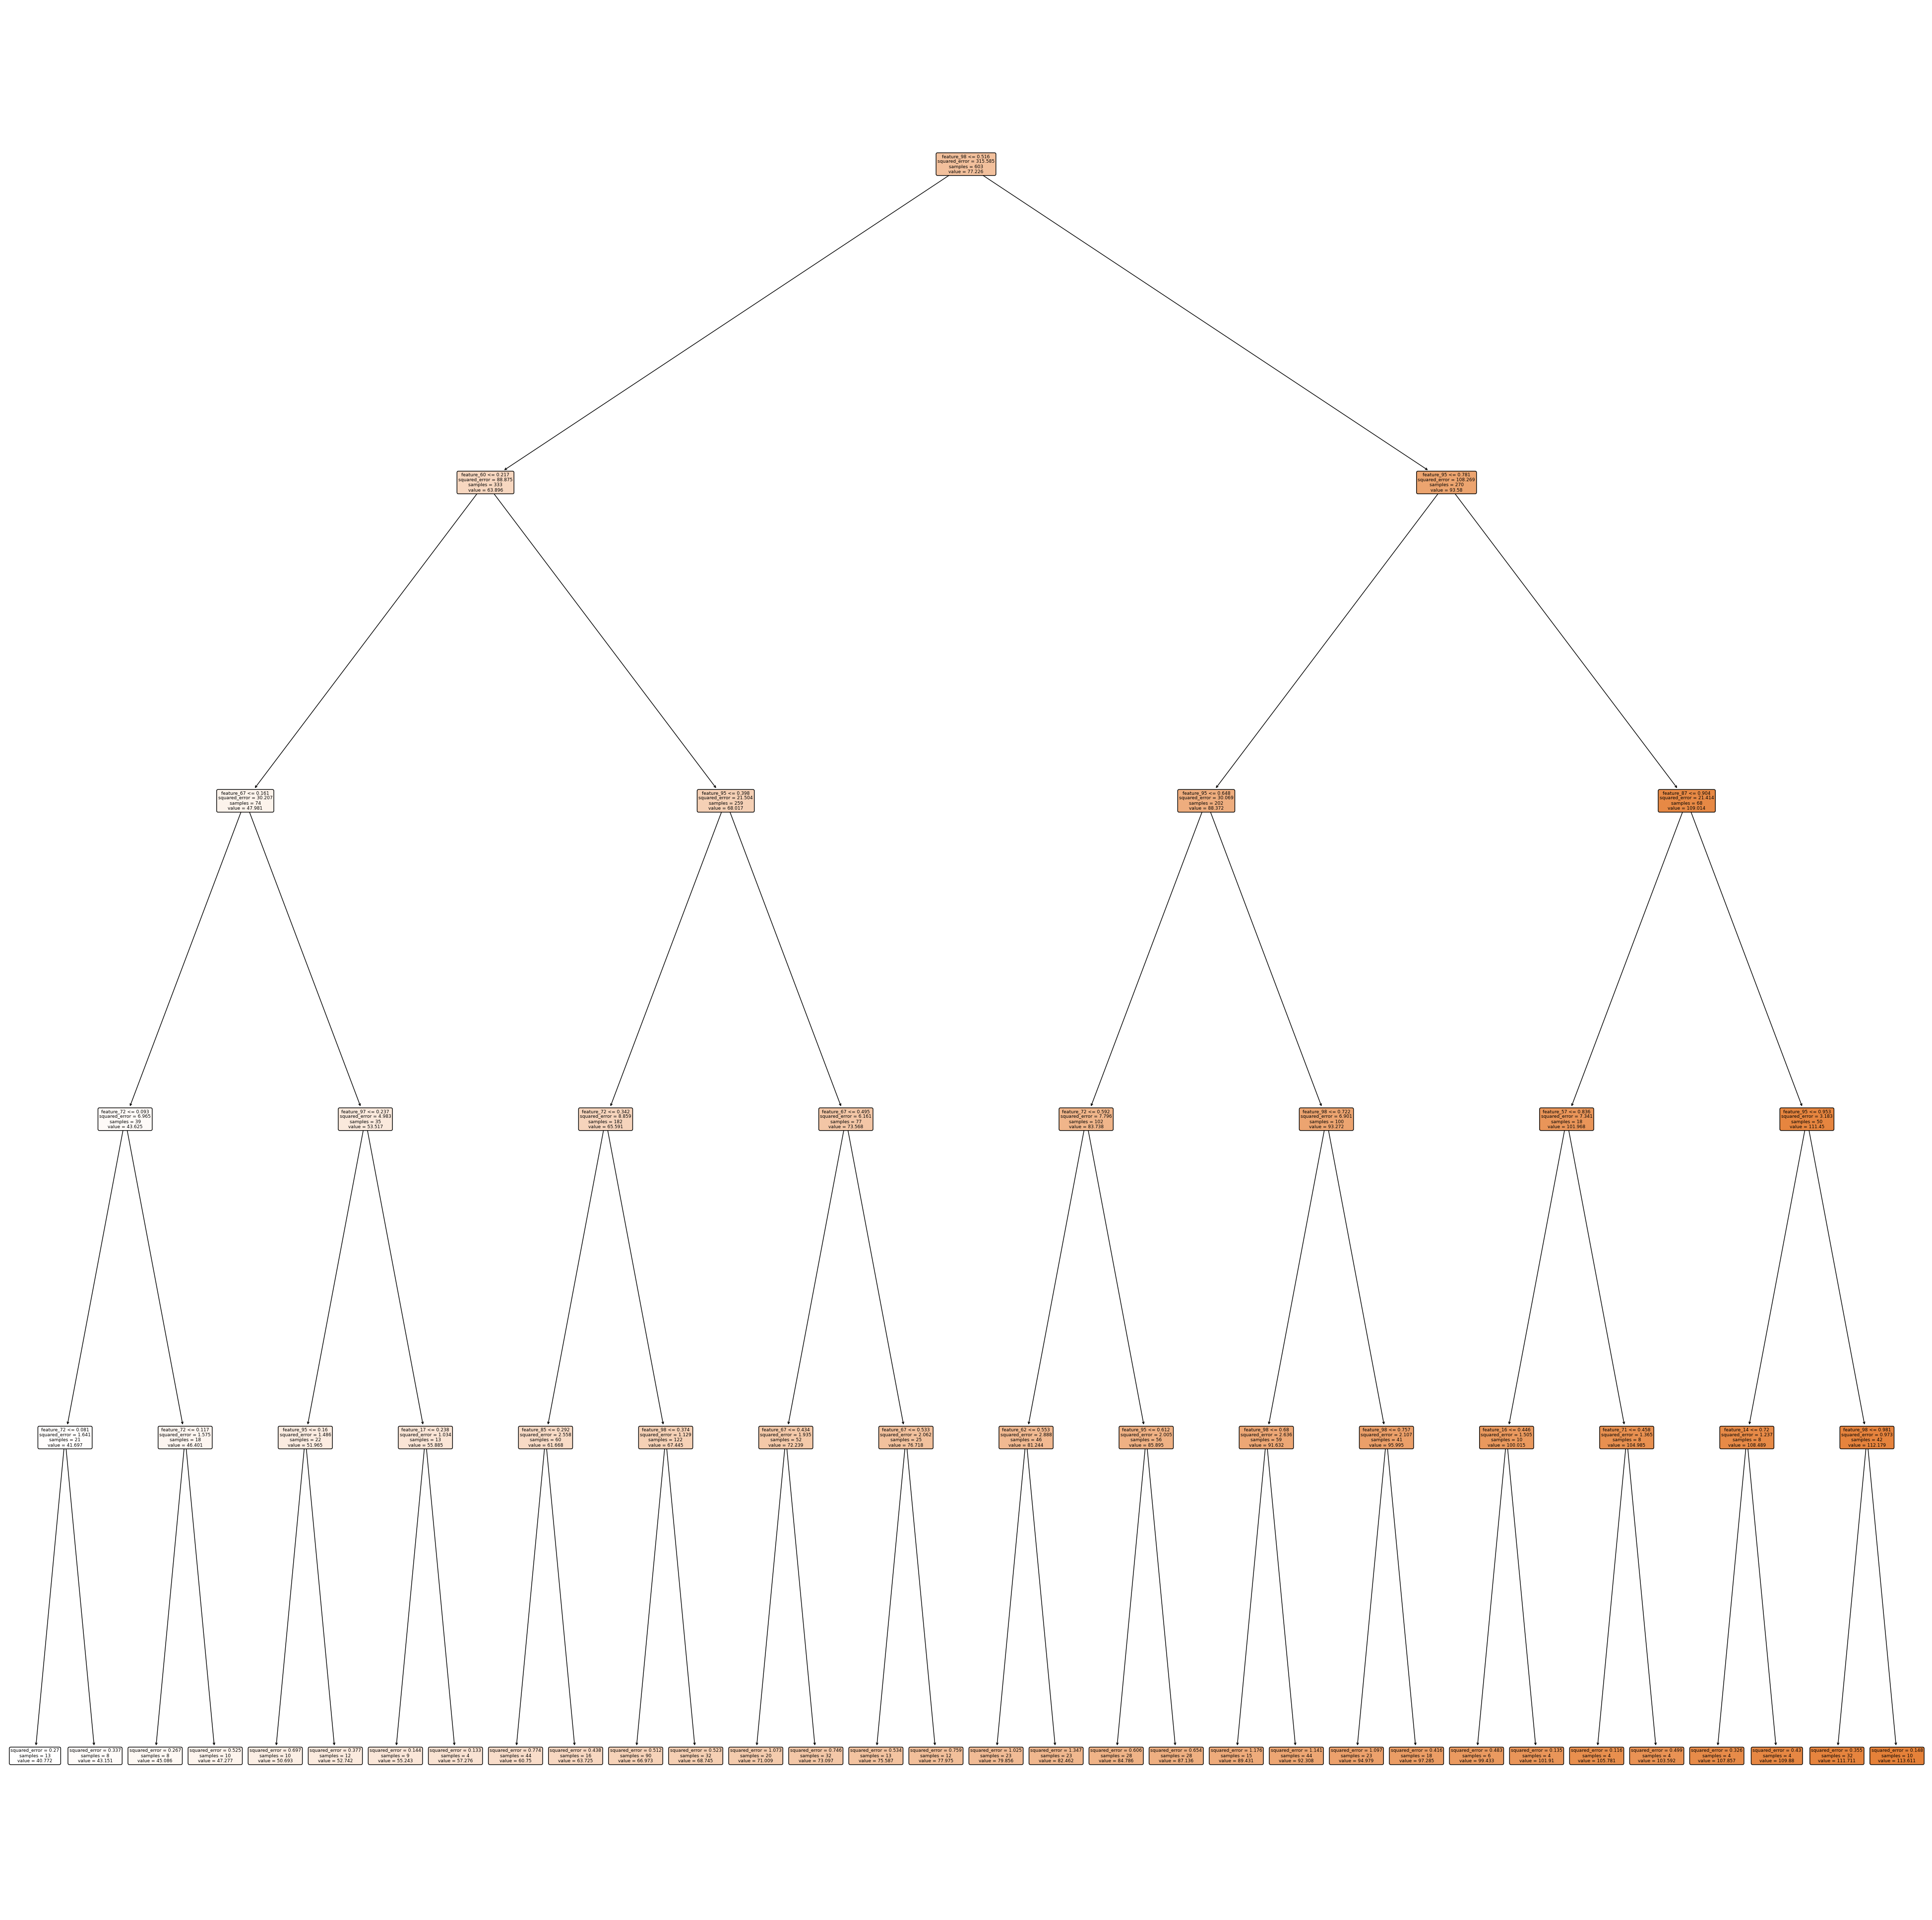

In [50]:
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Gerar os nomes das features automaticamente
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

# Seleciona uma árvore do modelo RandomForest
arvore = modelo_random_forest.estimators_[0]

# Plota a árvore
plt.figure(figsize=(50, 50))  # Ajuste o tamanho da figura
plot_tree(arvore, filled=True, feature_names=feature_names, rounded=True)
plt.show()



In [51]:
for tree_index in range(len(modelo_random_forest.estimators_)):
    tree = modelo_random_forest.estimators_[tree_index]
    predictions = tree.predict(X_test)
    print(f"Previsões da árvore {tree_index}: {predictions}")

Previsões da árvore 0: [73.09675941 73.09675941 73.09675941 73.09675941 73.09675941 73.09675941
 73.09675941 73.09675941 73.09675941 75.58686252 75.58686252 75.58686252
 75.58686252 75.58686252 75.58686252 75.58686252 75.58686252 73.09675941
 73.09675941 73.09675941 73.09675941 73.09675941 73.09675941 73.09675941
 71.00945974 71.00945974 71.00945974 71.00945974 71.00945974 71.00945974
 71.00945974 68.74531147 68.74531147 68.74531147 68.74531147 68.74531147
 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658
 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658
 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658
 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658 66.97255658
 66.97255658 63.72462072 63.72462072 63.72462072 63.72462072 63.72462072
 63.72462072 63.72462072 63.72462072 63.72462072 63.72462072 63.72462072
 63.72462072 60.7501614  60.7501614  60.7501614  60.7501614  60.7501614
 60.7501614  60.7501614  60.7

In [52]:
evaluate_model(y_test, y_pred)

{'MSE': 2.05502131595197,
 'MAE': 1.1465581609771776,
 'RMSE': 1.4335345534558872,
 'R2': 0.9015362288794069}

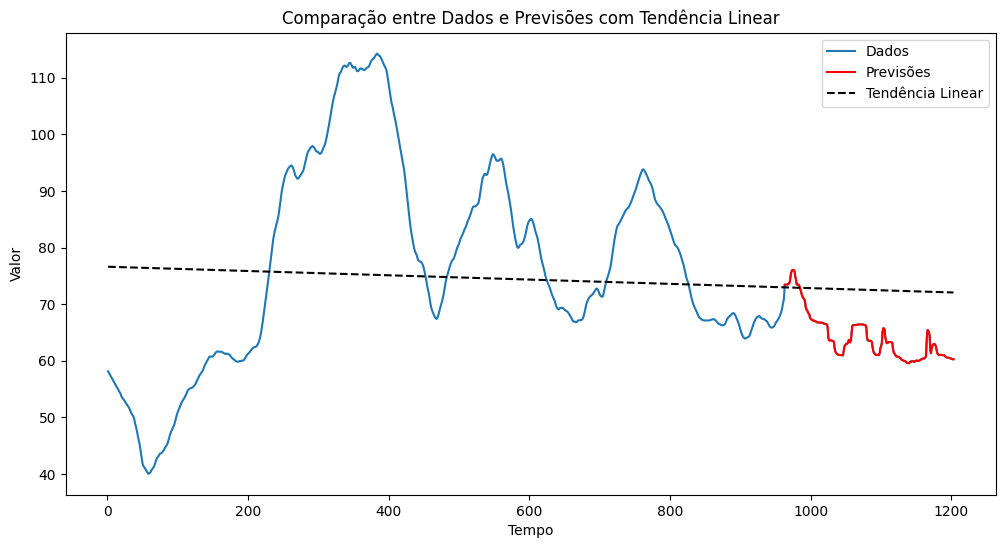

In [53]:
import matplotlib.pyplot as plt


# Assumindo que X_train[:, -1] contém os últimos valores usados para a primeira previsão
primeira_previsao = len(y_train) + 1  # Índice da primeira previsão

# Criando um array com os valores reais e as previsões
dados_plot = np.concatenate([dados['Close'][primeira_previsao-len(X_train[:, -1]):primeira_previsao], y_pred])
tempo = np.arange(primeira_previsao-len(X_train[:, -1]), primeira_previsao+len(y_pred))

# Calculando a regressão linear
coefs = np.polyfit(tempo, dados_plot, 1)  # Ajusta uma reta (grau 1)

# Criando a linha de tendência
poly1d_fn = np.poly1d(coefs)

# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(tempo, dados_plot, label='Dados')
plt.plot(tempo[len(X_train[:, -1]):], y_pred, label='Previsões', color='red')
plt.plot(tempo, poly1d_fn(tempo), '--k', label='Tendência Linear')
plt.title("Comparação entre Dados e Previsões com Tendência Linear")
plt.legend()
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.show()

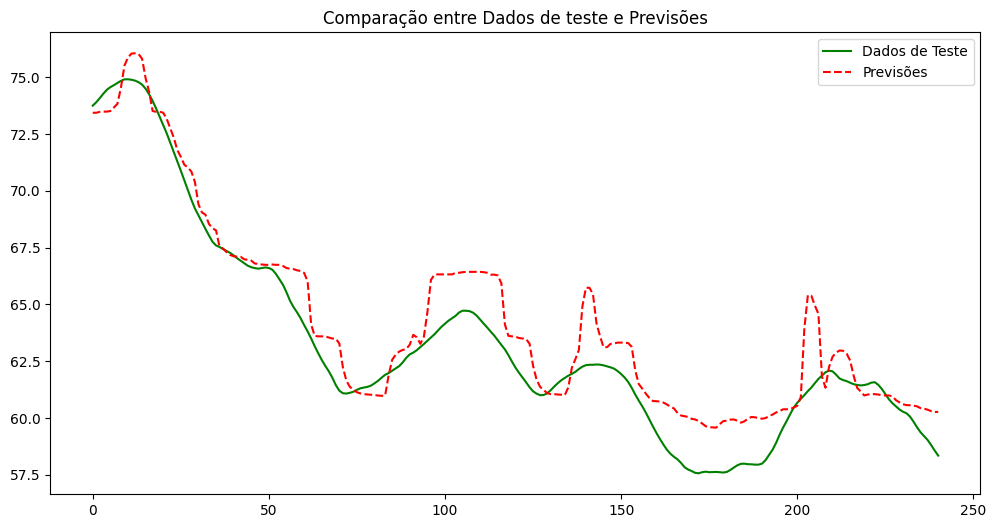

In [54]:
# Visualização das previsões
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Dados de Teste', color='green')
plt.plot(y_pred, color='red', linestyle='--', label='Previsões')
plt.title("Comparação entre Dados de teste e Previsões")
plt.legend()
plt.show()

In [55]:
evaluate_model(y_test, y_pred)

{'MSE': 2.05502131595197,
 'MAE': 1.1465581609771776,
 'RMSE': 1.4335345534558872,
 'R2': 0.9015362288794069}

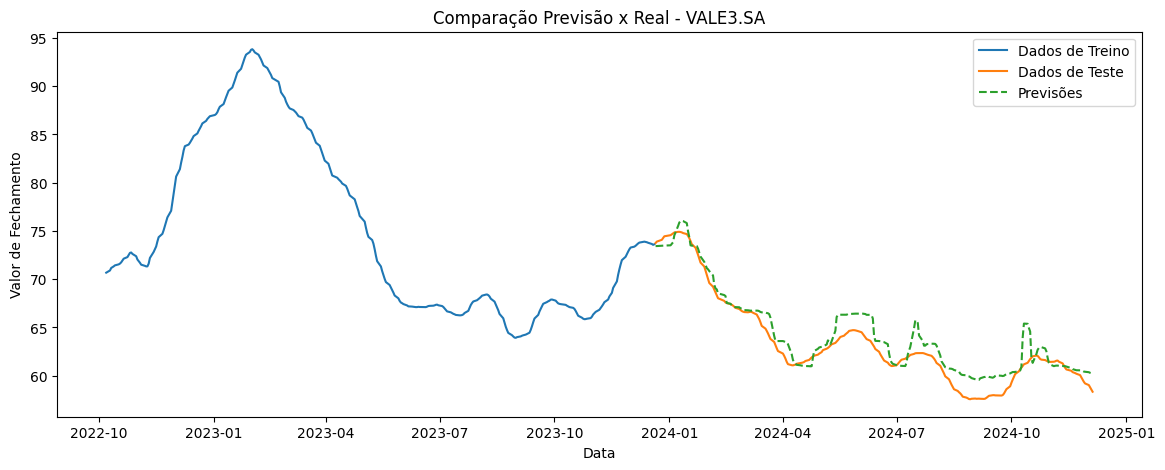

In [56]:
index_train = dados.index[:len(dados) - len(y_test)]
index_test = dados.index[len(dados) - len(y_test):]

# Valores reais de treino e teste
train_values = dados[target][:len(dados) - len(y_test)]
test_values = dados[target][len(dados) - len(y_test):]

# Plotando o gráfico
plt.figure(figsize=(14, 5))

# Plotando os valores reais de treino
plt.plot(index_train[-300:], train_values[-300:], label='Dados de Treino')

# Plotando os valores reais de teste
plt.plot(index_test[-300:], test_values[-300:], label='Dados de Teste')

# Plotando as previsões
plt.plot(index_test[-300:], y_pred[-300:], linestyle='--', label='Previsões')

plt.title('Comparação Previsão x Real - ' + EMPRESA)
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [57]:
dados_forward = dados.copy()
last_pred = y_pred[-1]
feed_preds = []


for d in range(days_to_predict):
    dados_forward = increment_data_df(dados_forward, last_pred, d)
    X_fwd, y_fwd, X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = split_X_y(dados_forward)
    X_fwd = X_fwd.reshape(X_fwd.shape[0], -1)

    last_pred = modelo_random_forest.predict(X_fwd[-n_past:-1])[-1]

    dados_forward.loc[dados_forward.index[-1], 'tomorrow'] = last_pred
    feed_preds.append(last_pred)

C:\Users\pedro\AppData\Local\Temp\ipykernel_12784\418165866.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\pedro\AppData\Local\Temp\ipykernel_12784\418165866.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [58]:
fig = go.Figure()

# Linha do dataset original 'dados'
fig.add_trace(go.Scatter(x=dados.index[-(days_to_predict*5):], 
                         y=dados[target][-(days_to_predict*5):], 
                         mode='lines', 
                         name='Dados Anteriores'))

# Linha dos dados previstos 'dados_forward'
fig.add_trace(go.Scatter(x=dados_forward.index[-(days_to_predict+1):], 
                         y=dados_forward[target][-(days_to_predict+1):], 
                         mode='lines', 
                         name='Previsões'))

# Ajuste dos rótulos do eixo x e rotação
fig.update_layout(
    xaxis=dict(tickangle=-90),  # Rotação vertical dos rótulos
    title="Previsão próximos 35 dias - " + EMPRESA,
    xaxis_title="Data",
    yaxis_title="Dados Anteriores",
    legend_title="Legenda",
    height=600,
    width=900
)

# Exibindo o gráfico
fig.show()